In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample

In [2]:

survey_template = {
    "Consent": {
        "text": "Do you agree to participate and allow your anonymized responses to be used "
                "for this research project? (Required to continue)",
        "type": "single_choice",
        "options": ["Yes", "No"],
        "required": True
    },
   
    "Q1_Age": {"text": "What is your age?", "type": "numeric", "required": True},
    "Q2_Gender": {"text": "Gender", "type": "single_choice", "options": ["Male","Female","Other"], "required": True},
    "Q3_Attendance": {"text": "Typical class attendance (%)", "type": "numeric", "required": True},
    "Q4_StudyHours": {"text": "Average study hours per week", "type": "numeric", "required": True},
    "Q5_TestScore": {"text": "Last exam test score (0-100)", "type": "numeric", "required": True},


    "Q6_WritingSkill": {"text": "Self-rated writing skill", "type": "single_choice",
                        "options": ["Poor","Weak","Fair","Good"], "required": True},
    "Q7_ReadingSkill": {"text": "Self-rated reading skill", "type": "single_choice",
                        "options": ["Poor","Weak","Fair","Good"], "required": True},
    "Q8_FrequentCold": {"text": "Do you frequently have colds? (affects attendance)", "type": "single_choice",
                        "options": ["Never","Sometimes","Often"], "required": False},
    "Q9_Extracurricular": {"text": "Do you attend extracurricular activities?", "type": "single_choice",
                           "options": ["Yes","No"], "required": False},
    "Q10_AdditionalComments": {"text": "Any additional comments (optional)", "type": "text", "required": False}
}


import json
print(json.dumps(survey_template, indent=2))

{
  "Consent": {
    "text": "Do you agree to participate and allow your anonymized responses to be used for this research project? (Required to continue)",
    "type": "single_choice",
    "options": [
      "Yes",
      "No"
    ],
    "required": true
  },
  "Q1_Age": {
    "text": "What is your age?",
    "type": "numeric",
    "required": true
  },
  "Q2_Gender": {
    "text": "Gender",
    "type": "single_choice",
    "options": [
      "Male",
      "Female",
      "Other"
    ],
    "required": true
  },
  "Q3_Attendance": {
    "text": "Typical class attendance (%)",
    "type": "numeric",
    "required": true
  },
  "Q4_StudyHours": {
    "text": "Average study hours per week",
    "type": "numeric",
    "required": true
  },
  "Q5_TestScore": {
    "text": "Last exam test score (0-100)",
    "type": "numeric",
    "required": true
  },
  "Q6_WritingSkill": {
    "text": "Self-rated writing skill",
    "type": "single_choice",
    "options": [
      "Poor",
      "Weak",
    

In [4]:
df = pd.read_csv("survey_responses.csv")


print("Shape:", df.shape)
display(df.head())

Shape: (120, 11)


,Consent,Q1_Age,Q2_Gender,Q3_Attendance,Q4_StudyHours,Q5_TestScore,Q6_WritingSkill,Q7_ReadingSkill,Q8_FrequentCold,Q9_Extracurricular,Q10_AdditionalComments
0,Yes,38,Female,40,3,53,Good,Fair,Often,No,NaN
1,No,22,Female,55,9,38,Fair,Good,Never,No,NaN
2,Yes,16,Male,100,4,90,Weak,Fair,Never,No,NaN
3,Yes,16,Other,78,8,73,Good,Fair,Sometimes,Yes,Health issues
4,Yes,35,Other,44,23,89,Poor,Weak,Often,Yes,Health issues


In [5]:
if 'Consent' in df.columns:
    df = df[df['Consent'].str.lower().str.contains("yes", na=False)]
    print("After filtering consented respondents:", df.shape)

After filtering consented respondents: (115, 11)


In [6]:
print(df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# Convert expected numeric columns
num_cols = ['Q1_Age','Q3_Attendance','Q4_StudyHours','Q5_TestScore']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

Consent                   object
Q1_Age                     int64
Q2_Gender                 object
Q3_Attendance              int64
Q4_StudyHours              int64
Q5_TestScore               int64
Q6_WritingSkill           object
Q7_ReadingSkill           object
Q8_FrequentCold           object
Q9_Extracurricular        object
Q10_AdditionalComments    object
dtype: object

Missing values per column:
 Consent                    0
Q1_Age                     0
Q2_Gender                  0
Q3_Attendance              0
Q4_StudyHours              0
Q5_TestScore               0
Q6_WritingSkill            0
Q7_ReadingSkill            0
Q8_FrequentCold            0
Q9_Extracurricular         0
Q10_AdditionalComments    46
dtype: int64


In [ ]:
display(df.describe(include='all'))


cat_cols = ['Q2_Gender','Q6_WritingSkill','Q7_ReadingSkill','Q8_FrequentCold','Q9_Extracurricular']
for c in cat_cols:
    if c in df.columns:
        print(f"\nValue counts for {c}:")
        print(df[c].value_counts(dropna=False))

,Consent,Q1_Age,Q2_Gender,Q3_Attendance,Q4_StudyHours,Q5_TestScore,Q6_WritingSkill,Q7_ReadingSkill,Q8_FrequentCold,Q9_Extracurricular,Q10_AdditionalComments
count,115,115.000000,115,115.000000,115.000000,115.000000,115,115,115,115,69
unique,1,NaN,3,NaN,NaN,NaN,4,4,3,2,3
top,Yes,NaN,Male,NaN,NaN,NaN,Weak,Weak,Sometimes,Yes,Needs more practice
freq,115,NaN,62,NaN,NaN,NaN,36,32,42,74,27
mean,NaN,26.939130,NaN,70.026087,14.252174,49.034783,NaN,NaN,NaN,NaN,NaN
std,NaN,7.724746,NaN,18.054722,8.251362,28.793253,NaN,NaN,NaN,NaN,NaN
min,NaN,16.000000,NaN,40.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,20.000000,NaN,55.000000,7.000000,24.500000,NaN,NaN,NaN,NaN,NaN
50%,NaN,26.000000,NaN,69.000000,15.000000,48.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,34.000000,NaN,86.500000,21.000000,73.500000,NaN,NaN,NaN,NaN,NaN



Value counts for Q2_Gender:
Q2_Gender
Male      62
Female    39
Other     14
Name: count, dtype: int64

Value counts for Q6_WritingSkill:
Q6_WritingSkill
Weak    36
Poor    31
Fair    29
Good    19
Name: count, dtype: int64

Value counts for Q7_ReadingSkill:
Q7_ReadingSkill
Weak    32
Fair    31
Poor    28
Good    24
Name: count, dtype: int64

Value counts for Q8_FrequentCold:
Q8_FrequentCold
Sometimes    42
Often        38
Never        35
Name: count, dtype: int64

Value counts for Q9_Extracurricular:
Q9_Extracurricular
Yes    74
No     41
Name: count, dtype: int64


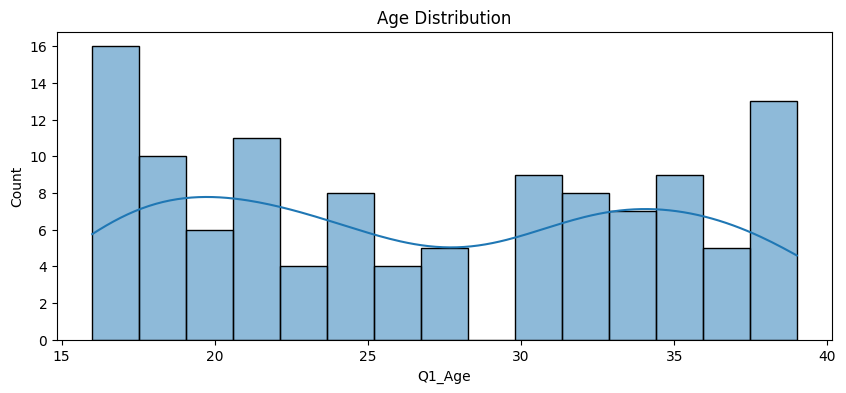

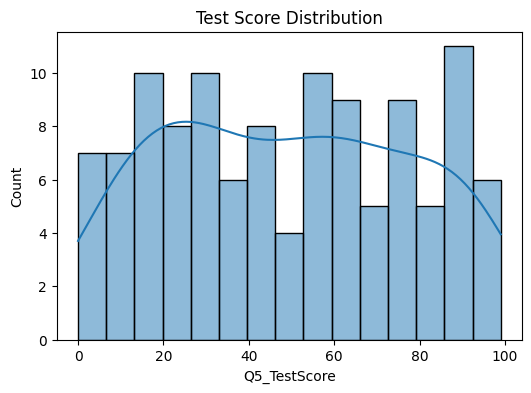

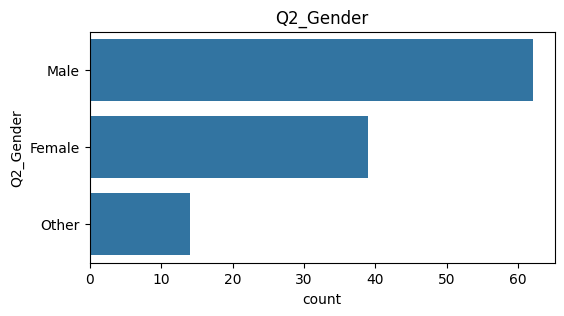

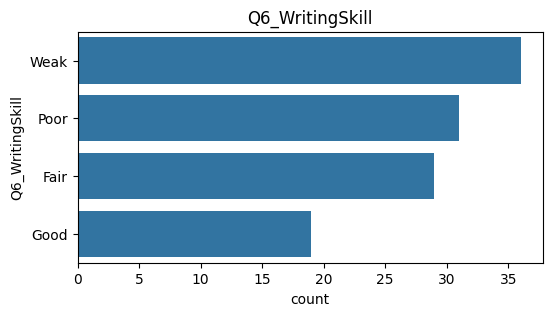

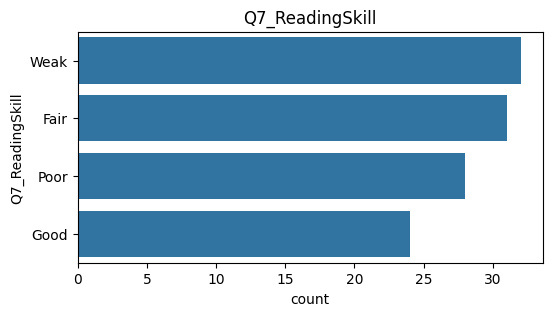

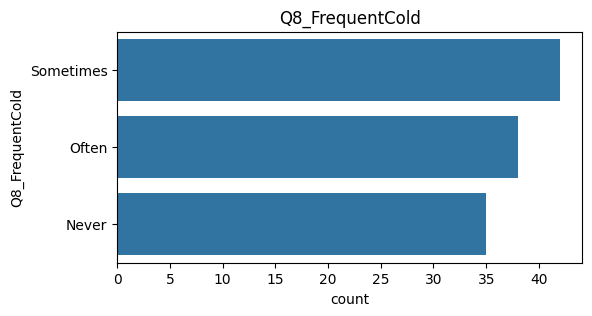

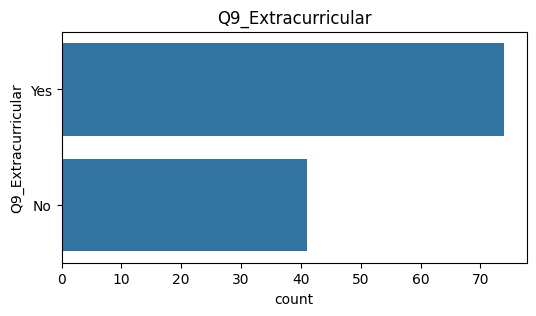

In [ ]:
plt.figure(figsize=(10,4))
if 'Q1_Age' in df.columns:
    sns.histplot(df['Q1_Age'].dropna(), kde=True, bins=15)
    plt.title("Age Distribution")
    plt.show()

# B. Distribution of Test Score
if 'Q5_TestScore' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['Q5_TestScore'].dropna(), kde=True, bins=15)
    plt.title("Test Score Distribution")
    plt.show()

# C. Bar charts for categorical features
for c in ['Q2_Gender','Q6_WritingSkill','Q7_ReadingSkill','Q8_FrequentCold','Q9_Extracurricular']:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(y=c, data=df, order=df[c].value_counts().index)
        plt.title(c)
        plt.show()

target
1    60
0    55
Name: count, dtype: int64


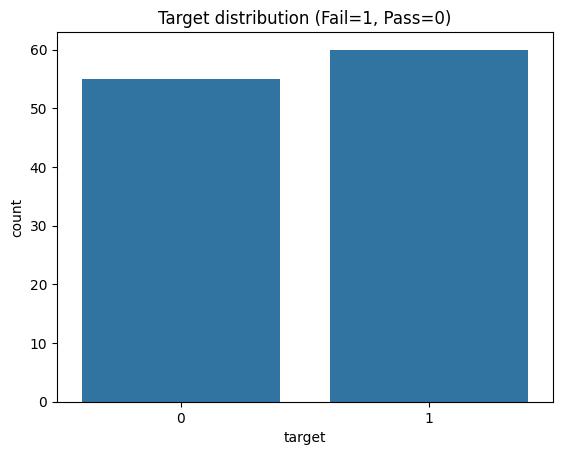

In [9]:
if 'Q5_TestScore' in df.columns:
    df['target'] = np.where(df['Q5_TestScore'] < 50, 1, 0)
    print(df['target'].value_counts())
    sns.countplot(x='target', data=df)
    plt.title("Target distribution (Fail=1, Pass=0)")
    plt.show()
else:
    print("No Q5_TestScore column found. Choose a suitable target column before running balance checks.")

In [10]:
num_cols_present = [c for c in num_cols if c in df.columns]
for c in num_cols_present:
    skew = df[c].dropna().skew()
    if abs(skew) > 1:
        # skewed: use median
        df[c].fillna(df[c].median(), inplace=True)
    else:
        df[c].fillna(df[c].mean(), inplace=True)

# 2) Categorical: impute with mode or create "Missing" category
for c in cat_cols:
    if c in df.columns:
        df[c].fillna(df[c].mode().iloc[0], inplace=True)

print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 Consent                    0
Q1_Age                     0
Q2_Gender                  0
Q3_Attendance              0
Q4_StudyHours              0
Q5_TestScore               0
Q6_WritingSkill            0
Q7_ReadingSkill            0
Q8_FrequentCold            0
Q9_Extracurricular         0
Q10_AdditionalComments    46
target                     0
dtype: int64


C:\Users\Naveed Sheikh\AppData\Local\Temp\ipykernel_15332\2197702059.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].mean(), inplace=True)
C:\Users\Naveed Sheikh\AppData\Local\Temp\ipykernel_15332\2197702059.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Balanced shape (after oversampling minority): (110, 12)


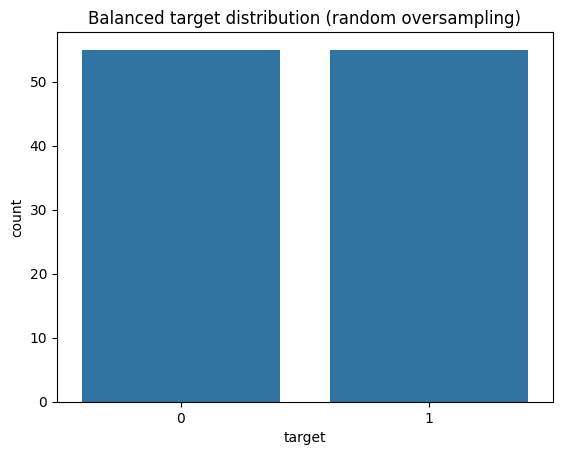

In [11]:
if 'target' in df.columns:
    df_majority = df[df.target==0]
    df_minority = df[df.target==1]

    if len(df_minority) == 0 or len(df_majority) == 0:
        print("Not enough classes to resample.")
    else:
        df_minority_upsampled = resample(df_minority,
                                         replace=True,
                                         n_samples=len(df_majority),
                                         random_state=42)
        df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
        print("Balanced shape (after oversampling minority):", df_balanced.shape)
        sns.countplot(x='target', data=df_balanced)
        plt.title("Balanced target distribution (random oversampling)")
        plt.show()

In [12]:
feature_cols = [c for c in df.columns if c not in ['target','Consent','Q10_AdditionalComments']]  # drop text/consent columns
# Convert categorical to numeric codes temporarily for mutual_info
X = df[feature_cols].copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category').cat.codes

y = df['target'] if 'target' in df.columns else None

if y is not None:
    mi = mutual_info_classif(X.fillna(0), y, discrete_features='auto', random_state=42)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    print("Mutual Information scores:\n", mi_series)
    # select features with MI score > small threshold (choose threshold as needed)
    selected_features_mi = mi_series[mi_series > 0.01].index.tolist()
    print("\nSelected features (mutual info > 0.01):", selected_features_mi)
else:
    print("Target variable not available for feature selection.")

Mutual Information scores:
 Q5_TestScore          0.696568
Q2_Gender             0.058034
Q6_WritingSkill       0.039304
Q9_Extracurricular    0.024480
Q1_Age                0.000000
Q4_StudyHours         0.000000
Q3_Attendance         0.000000
Q7_ReadingSkill       0.000000
Q8_FrequentCold       0.000000
dtype: float64

Selected features (mutual info > 0.01): ['Q5_TestScore', 'Q2_Gender', 'Q6_WritingSkill', 'Q9_Extracurricular']


In [13]:
cat_vars_present = [c for c in cat_cols if c in df.columns]

# Example: use pandas get_dummies with drop_first=True for dummy encoding (k-1)
df_dummies = pd.get_dummies(df, columns=cat_vars_present, drop_first=True)

print("Columns after dummy encoding:", [c for c in df_dummies.columns if any(prefix in c for prefix in cat_vars_present)][:10])

Columns after dummy encoding: ['Q2_Gender_Male', 'Q2_Gender_Other', 'Q6_WritingSkill_Good', 'Q6_WritingSkill_Poor', 'Q6_WritingSkill_Weak', 'Q7_ReadingSkill_Good', 'Q7_ReadingSkill_Poor', 'Q7_ReadingSkill_Weak', 'Q8_FrequentCold_Often', 'Q8_FrequentCold_Sometimes']


In [15]:
df_dummies.to_csv("survey_processed.csv", index=False)
print("Saved survey_processed.csv")

Saved survey_processed.csv
